We have learned how to implement a model and train it from stratch. However, for pratical machine learning tasks, we often reuse popular model architectures and load pre-trained weights on famous large datasets and fine-tune with our own small, specific dataset, which is called transfer learning. In this notebook we will load a pre-trained ConvNet and use it for our own goal.

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import utils
import os

2.0.0-alpha0


You can find famous ConvNets in keras.applications.

In [2]:
baseModel = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet',include_top=False)
baseModel.trainable = False
cnnModel = keras.Sequential([baseModel,layers.Flatten(),
                  layers.Dense(units = 512, activation = 'relu'), 
                  layers.Dense(units = 10, activation = 'softmax')])
cnnModel.summary()
print("Number of layers in VGG16: ", len(baseModel.layers))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 27,565,386
Trainable params: 12,850,698
Non-trainable params: 14,714,688
_________________________________________________________________
Number of layers in VGG16:  19


In [ ]:
filenames = []
labels = []
class_names = ['bird','cat','dog']
for filename in os.listdir("./data"):
    filenames.append(os.path.join("./data",filename))
    if filename.startswith("bird"):
        labels.append(0)
    elif filename.startswith("cat"):
        labels.append(1)
    else:
        labels.append(2)
print(filenames)
print(labels)
path_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [ ]:
def load_and_preprocess_image(filename, label):
    raw_image = tf.io.read_file(filename)
    image_tensor = tf.image.decode_jpeg(raw_image)
    image_tensor = tf.image.resize(image_tensor, [224, 224])
    image_tensor /= 255.0
    return image_tensor,label

In [3]:
imageDataset = path_dataset.map(load_and_preprocess_image)
trainDataset = imageDataset.take(int(len(filenames)* 0.7))
testDataset = imageDataset.skip(int(len(filenames)* 0.7))

['./data/bird (20)', './data/dog (33)', './data/dog (28)', './data/bird (19)', './data/cat (18)', './data/dog (13)', './data/cat (8)', './data/bird (38)', './data/bird (7)', './data/bird (25)', './data/dog (17)', './data/cat (29)', './data/cat (40)', './data/bird (29)', './data/dog (16)', './data/cat (27)', './data/bird (16)', './data/dog (2)', './data/bird (5)', './data/dog (18)', './data/cat (22)', './data/dog (12)', './data/bird (36)', './data/bird (14)', './data/dog (29)', './data/dog (24)', './data/bird (12)', './data/dog (27)', './data/cat (15)', './data/dog (7)', './data/cat (25)', './data/bird (31)', './data/bird (8)', './data/cat (16)', './data/dog (40)', './data/dog (8)', './data/cat (37)', './data/bird (17)', './data/bird (10)', './data/cat (20)', './data/cat (28)', './data/cat (5)', './data/cat (6)', './data/dog (22)', './data/bird (35)', './data/dog (30)', './data/cat (35)', './data/dog (37)', './data/cat (17)', './data/dog (35)', './data/dog (36)', './data/bird (28)', './

In [4]:
cnnModel.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
             loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [5]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
]
history = cnnModel.fit(trainDataset.shuffle(5).repeat().batch(5), epochs=20, steps_per_epoch=50, validation_data=testDataset.repeat().batch(10), validation_steps=10, callbacks = callbacks)

Epoch 1/20
50/50 [==============================] - 46s 914ms/step - loss: 0.7890 - accuracy: 0.7200 - val_loss: 0.7084 - val_accuracy: 0.7500
Epoch 2/20
50/50 [==============================] - 44s 887ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.5620 - val_accuracy: 0.7800
Epoch 3/20
50/50 [==============================] - 44s 879ms/step - loss: 0.0185 - accuracy: 0.9920 - val_loss: 0.6596 - val_accuracy: 0.7800
Epoch 4/20
50/50 [==============================] - 44s 875ms/step - loss: 2.6979e-04 - accuracy: 1.0000 - val_loss: 0.8508 - val_accuracy: 0.7500


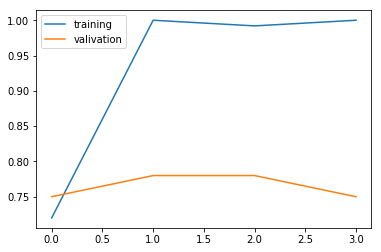

In [6]:
# history record the accuracy/loss on training set/validation set after every epoch 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()

In [7]:
result = cnnModel.evaluate(testDataset.batch(10))

4/4 [==============================] - 4s 1s/step - loss: 0.8318 - accuracy: 0.7500


In [8]:
predict_result = tf.argmax(cnnModel.predict(testDataset.take(9).batch(9)),axis=1)

In [9]:
predict_result.numpy()

array([2, 2, 0, 2, 1, 0, 1, 2, 0])

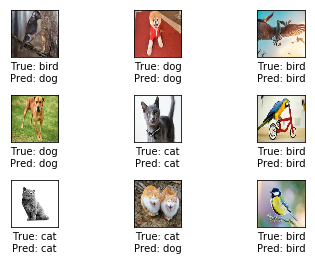

In [10]:
utils.show_images(testDataset, class_names, predict_result)